<a href="https://colab.research.google.com/github/shreyash-99/EVA8/blob/main/Session_10_Partial_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

In [ ]:
DATA_DIR='./data'

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [ ]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [ ]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        
        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)
        
        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)
        
        att = keys.transpose(-2, -1) @ queries
        
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))
        
        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out
    
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1)   
        )

In [ ]:
class TransformerBlock(nn.Sequential):
    def __init__(self, channels, head_channels, shape, p_drop=0.):
        super().__init__(
            Residual(
                LayerNormChannels(channels),
                SelfAttention2d(channels, channels, head_channels, shape),
                nn.Dropout(p_drop)
            ),
            Residual(
                LayerNormChannels(channels),
                FeedForward(channels, channels),
                nn.Dropout(p_drop)
            )
        )

In [ ]:
class TransformerStack(nn.Sequential):
    def __init__(self, num_blocks, channels, head_channels, shape, p_drop=0.):
        layers = [TransformerBlock(channels, head_channels, shape, p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

In [ ]:
class ToPatches(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, hidden_channels=32):
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, patch_size, stride=patch_size)
        )

In [ ]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, channels, shape):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(channels, *shape))
    
    def forward(self, x):
        return x + self.pos_embedding

In [ ]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, shape, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, channels, patch_size),
            AddPositionEmbedding(channels, shape),
            nn.Dropout(p_drop)
        )

In [ ]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [ ]:
class ViT(nn.Sequential):
    def __init__(self, classes, image_size, channels, head_channels, num_blocks, patch_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)  # shape of the patch
        super().__init__(
            ToEmbedding(in_channels, channels, patch_size, shape, emb_p_drop),
            TransformerStack(num_blocks, channels, head_channels, shape, trans_p_drop),
            Head(channels, classes, head_p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, SelfAttention2d):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        # assert len(parameters_decay & parameters_no_decay) == 0
        # assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [ ]:
NUM_CLASSES, IMAGE_SIZE = 10, 32
model = ViT(NUM_CLASSES, IMAGE_SIZE, channels=32, head_channels=8, num_blocks=4, patch_size=2,
               emb_p_drop=0., trans_p_drop=0., head_p_drop=0.1)

In [ ]:
model.to(DEVICE)

ViT(
  (0): ToEmbedding(
    (0): ToPatches(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (1): AddPositionEmbedding()
    (2): Dropout(p=0.0, inplace=False)
  )
  (1): TransformerStack(
    (0): TransformerBlock(
      (0): Residual(
        (residual): Sequential(
          (0): LayerNormChannels(
            (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SelfAttention2d(
            (to_keys): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (to_queries): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (to_values): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (unifyheads): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Residual(
        (residual): Sequential(
          (0): La

In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 79,810


In [ ]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 25

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
import time

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ConvMixer: Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


ConvMixer: Epoch: 0 | Train Acc: 0.2077, Test Acc: 0.3804, Time: 71.1, lr: 0.001000
ConvMixer: Epoch: 1 | Train Acc: 0.3638, Test Acc: 0.4446, Time: 64.5, lr: 0.002000
ConvMixer: Epoch: 2 | Train Acc: 0.4506, Test Acc: 0.5433, Time: 64.6, lr: 0.003000
ConvMixer: Epoch: 3 | Train Acc: 0.4920, Test Acc: 0.5043, Time: 66.1, lr: 0.004000
ConvMixer: Epoch: 4 | Train Acc: 0.5218, Test Acc: 0.5782, Time: 67.2, lr: 0.005000
ConvMixer: Epoch: 5 | Train Acc: 0.5314, Test Acc: 0.5841, Time: 67.6, lr: 0.006000
ConvMixer: Epoch: 6 | Train Acc: 0.5520, Test Acc: 0.5950, Time: 67.2, lr: 0.007000
ConvMixer: Epoch: 7 | Train Acc: 0.5668, Test Acc: 0.5906, Time: 69.1, lr: 0.008000
ConvMixer: Epoch: 8 | Train Acc: 0.5724, Test Acc: 0.5900, Time: 68.2, lr: 0.009000
ConvMixer: Epoch: 9 | Train Acc: 0.5840, Test Acc: 0.6308, Time: 67.9, lr: 0.010000
ConvMixer: Epoch: 10 | Train Acc: 0.6012, Test Acc: 0.6330, Time: 69.2, lr: 0.009050
ConvMixer: Epoch: 11 | Train Acc: 0.6216, Test Acc: 0.6466, Time: 68.0, lr:

Analysising positional encoding 


In [ ]:
## self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1)* (2* width - 1 )))
## creates no of heads times the specific matrix(3*3 in this case) 
torch.Tensor(2, (2 * 2 - 1) * (2 * 2 -1))

tensor([[-9.5359e-06,  4.5863e-41,  2.8276e-34,  0.0000e+00, -9.5359e-06,
          4.5863e-41, -9.5359e-06,  4.5863e-41,  0.0000e+00],
        [ 0.0000e+00,  1.4013e-45,  0.0000e+00,  0.0000e+00,  1.4013e-45,
          1.5414e-44,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [ ]:
##   rel_pos_enc = self.pos_enc.gather(-1, indices)
t = torch.tensor([[1,2],[3,4]])
## gather allows to capture or rearange the data as we want.
torch.gather(t, 1, torch.tensor([[0,0],[1,0]]))
##  argument 2 i.e. 1 makes sure we are focusing om the rows.
## for the first row - repeat the first element twice
## for the second row, 2nd elemnt at first place and first element at second place 


tensor([[1, 1],
        [4, 3]])

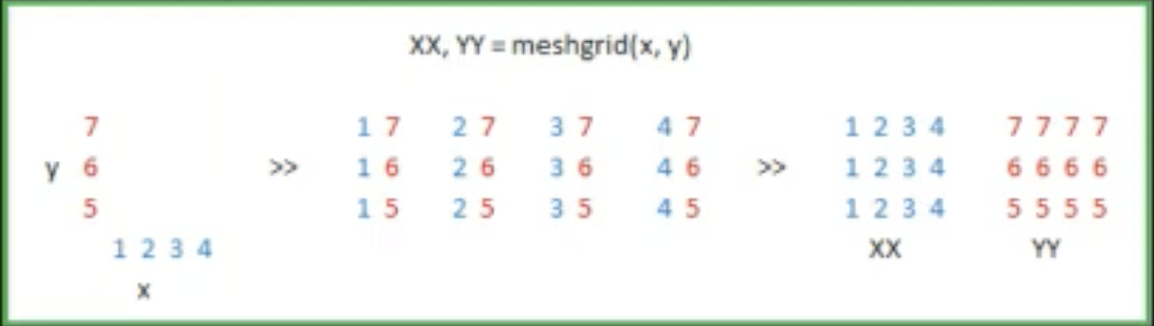

In [ ]:
def get_indices(h = 4, w = 4):
    y = torch.arange(h, dtype = torch.long)
    x = torch.arange(w, dtype = torch.long)

    y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing = 'ij')
    return y1

get_indices()

tensor([[[[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],

         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],

         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]],

         [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]],


        [[[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]],

         [[1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1],
          [1, 1, 1, 1]]],


        [[[2, 2, 2, 2],
          [2, 2, 2, 2],
          [2, 2, 2, 2],
          [2, 2, 2, 2]],

         [[2, 2, 2, 2],
          [2, 2, 2, 2],
          [2, 2, 2, 2],
          [2, 2, 2, 2]],

         [[2, 2,